In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
sys.path.append("/content/drive/My Drive/phd/")
sys.path.append("/content/drive/My Drive/phd/master_thesis/hsbm/")
from hsbmpy import get_max_available_L

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#label = 'disease_type'
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/datasets/merged'
L = get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [60]:
label = 'status'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head()

,primary_site,status,dataset,tissue_hd
TCGA-E8-A2JQ-11A-11R-A180-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-EL-A3ZK-11A-11R-A23N-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-BJ-A28X-11A-11R-A22L-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-BJ-A28R-11A-11R-A16R-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-EL-A3T8-11A-11R-A22L-07,Thyroid,healthy,tcga,Thyroid_healthy


## Projection based predictions

In [0]:
df_Pst = pd.DataFrame(data=pd.np.matmul(df.values,df_words.values), index= df.index, columns=df_words.columns)
df_Pst = df_Pst.divide(df_Pst.sum(1), 0)
predictions = pd.np.array(list(map(lambda x: list(map(lambda y: entropy(x, y), df_topic_tissue.astype(float).values)), df_Pst.astype(float).values)))

df_Pst.insert(0,'tissue', df_files.reindex(index=df_Pst.index)[label])
reals = pd.np.unique(df_Pst.tissue, return_inverse=True)[1]

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [0]:
accuracy_score(reals, pd.np.argmin(predictions, axis=1))

0.74125

## NN based predictor

In [131]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution1D
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6983002521313275200, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9119026879359363721
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16271252724238021587
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2030628650977901883
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [287]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1).divide(df_topics.drop('tissue',1).mean(0),1).values.astype(float)
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
inputs = X_train.shape[1]

if uniq==2:
  Y_train = np.abs((np.argmax(Y_train, axis=-1)-1)) #1="healthy"
  uniq=1
  activation_func="sigmoid"
else:
  activation_func="softmax"

classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

X_tm_train, X_tm_test, Y_tm_train, Y_tm_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.95)

print(X_train.shape, Y_train.shape, X_tm_train.shape, Y_tm_train.shape)

(800, 235) (800,) (760, 235) (760,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               23600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 23,701
Trainable params: 23,701
Non-trainable params: 0
_________________________________________________________________
None


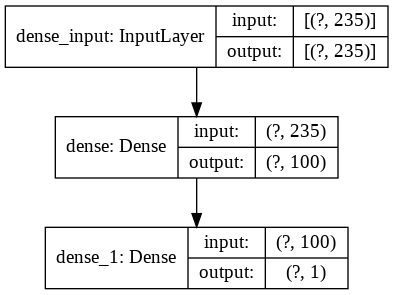

In [288]:
K.clear_session()

os.system("rm -rf log.csv")
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, mode='min', patience=25)

model=Sequential()
model.add(Dense(units=100, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=0.01, l2=0.0001)))
model.add(Dense(units=uniq, activation=activation_func))
model.compile(loss=binary_crossentropy, optimizer=SGD(lr=0.001, momentum=0.9), metrics=['accuracy', 'AUC'])
K.set_learning_phase(0)

print(model.summary())
plot_model(model, show_shapes=True)


In [289]:
with tf.device("GPU"):
    model.fit(X_tm_train, Y_tm_train, epochs=1000, batch_size=500, verbose=1, validation_split=0.25, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)

Epoch 1/1000
2/2 [==============================] - 0s 123ms/step - loss: 17.7620 - accuracy: 0.4930 - auc: 0.4601 - val_loss: 17.7282 - val_accuracy: 0.4158 - val_auc: 0.3985
Epoch 2/1000
2/2 [==============================] - 0s 19ms/step - loss: 17.3585 - accuracy: 0.4982 - auc: 0.4697 - val_loss: 17.6728 - val_accuracy: 0.4158 - val_auc: 0.4111
Epoch 3/1000
2/2 [==============================] - 0s 17ms/step - loss: 17.5297 - accuracy: 0.5018 - auc: 0.4885 - val_loss: 17.5919 - val_accuracy: 0.3947 - val_auc: 0.4267
Epoch 4/1000
2/2 [==============================] - 0s 17ms/step - loss: 16.9623 - accuracy: 0.5123 - auc: 0.5179 - val_loss: 17.4861 - val_accuracy: 0.4000 - val_auc: 0.4448
Epoch 5/1000
2/2 [==============================] - 0s 20ms/step - loss: 17.1061 - accuracy: 0.5228 - auc: 0.5499 - val_loss: 17.3664 - val_accuracy: 0.4105 - val_auc: 0.4623
Epoch 6/1000
2/2 [==============================] - 0s 19ms/step - loss: 16.9564 - accuracy: 0.5491 - auc: 0.5825 - val_loss

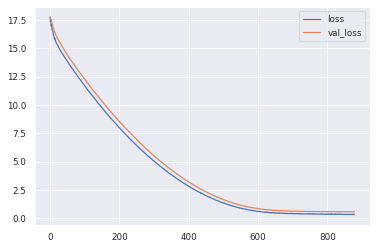

In [291]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [292]:
model.evaluate(X_tm_test, Y_tm_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.4275 - accuracy: 0.8750 - auc: 0.9698


[0.4275018572807312, 0.875, 0.9697802662849426]

In [0]:
model.save("model_hd.h5")
#model = load_model("model.h5")

In [68]:
gc.collect()

4999

# evaluate on non used on topsbm training


In [0]:
df_test_table = pd.read_csv("mainTable_test.csv", index_col = 0)

In [159]:
#get only HV genes
df_test = df_test_table.reindex(index=df_words.index)

df_test = df_test.divide(df_test.sum(0),1).transpose().fillna(0)

df_test = pd.DataFrame(data=np.matmul(df_test.values,df_words.values), index=df_test.index, columns=df_words.columns)
df_test=df_test.divide(df_test.mean(axis=0), axis=1) #normalize P(t|d)
df_test.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31,Topic 32,Topic 33,Topic 34,Topic 35,Topic 36,Topic 37,Topic 38,Topic 39,Topic 40,...,Topic 196,Topic 197,Topic 198,Topic 199,Topic 200,Topic 201,Topic 202,Topic 203,Topic 204,Topic 205,Topic 206,Topic 207,Topic 208,Topic 209,Topic 210,Topic 211,Topic 212,Topic 213,Topic 214,Topic 215,Topic 216,Topic 217,Topic 218,Topic 219,Topic 220,Topic 221,Topic 222,Topic 223,Topic 224,Topic 225,Topic 226,Topic 227,Topic 228,Topic 229,Topic 230,Topic 231,Topic 232,Topic 233,Topic 234,Topic 235
TCGA-VN-A88P-01A-11R-A352-07,0.286860,0.006081,0.014705,0.098523,0.020375,0.029710,0.073698,0.360171,0.473814,0.772392,0.059265,0.028101,0.187931,9.040754,0.001627,0.313948,2.197697,2.721850,1.051406,1.800013,0.701534,1.019496,0.102440,0.147019,0.000000,0.095379,0.000000,0.435124,0.006450,0.0,1.721200,0.679884,0.000000,0.087329,0.911828,0.201382,0.002741,0.016462,1.937221,3.255274,...,0.496707,0.090883,0.000000,0.031817,0.029627,0.0,0.001956,0.141083,0.816975,0.0,1.217420,0.000000,0.0,0.000000,0.335473,0.000000,1.215671,2.072216,0.274378,0.000000,0.000000,0.0,1.969381,0.605642,0.070599,0.000000,0.166264,5.663715,0.287929,0.0,0.0,0.000000,0.796637,5.284775,7.241109,0.000000,0.0,0.0,0.008073,0.000000
TCGA-CH-5739-01A-11R-1580-07,0.395807,0.012349,0.036603,0.090145,0.079337,0.118457,0.094612,0.025608,1.106303,0.470970,0.236235,0.017221,0.132275,0.935951,0.005005,0.367600,6.729537,2.338866,1.778006,0.922447,0.000000,0.927136,0.098823,0.026736,0.000000,0.037194,0.000000,0.984776,0.037815,0.0,1.943861,1.897306,0.000000,0.000000,1.272857,0.595780,0.002659,0.116957,3.608197,5.598607,...,1.250566,0.194539,0.000000,0.086289,0.046690,0.0,0.011039,0.308608,0.172383,0.0,0.859053,0.003203,0.0,0.003405,0.012705,0.115376,1.002383,0.726750,0.000000,0.587647,0.118484,0.0,1.103319,0.665797,0.052551,13.423387,1.931101,16.427194,0.000000,0.0,0.0,0.000000,0.833348,0.000000,5.038534,0.586538,0.0,0.0,2.171589,0.545335
TCGA-V1-A9OH-01A-11R-A41O-07,0.340277,0.032712,0.036728,0.014309,0.060879,0.190469,0.020167,0.138148,0.808482,0.424407,0.139633,0.014962,0.280405,1.506465,0.001997,1.110613,5.660702,2.381075,1.040727,1.656783,0.875347,0.704720,0.042668,0.026263,0.069769,0.182641,0.000000,0.560544,0.105232,0.0,2.287419,0.244959,0.014885,0.304012,1.108903,0.411065,0.001005,0.034030,2.032033,3.606580,...,1.539677,0.348490,0.000000,0.038570,0.136200,0.0,0.008787,0.244068,0.135433,0.0,0.460534,0.230266,0.0,0.002582,0.066280,0.023732,0.605242,0.576313,0.194837,0.122136,0.009874,0.0,0.000000,0.111964,0.439560,0.000000,1.233660,18.798564,0.547692,0.0,0.0,0.000000,0.640219,0.000000,0.000000,0.454763,0.0,0.0,0.207530,0.000000
TCGA-EJ-7331-01A-11R-2118-07,0.465609,0.021171,0.013290,0.014640,0.107007,0.134686,0.017426,0.019949,1.052003,0.466466,0.301864,0.012020,0.131487,0.679612,0.002125,0.356096,5.843611,3.040497,1.467301,0.889800,0.352837,0.937263,0.177806,0.070958,0.000000,0.068137,64.156346,0.918419,0.033471,0.0,2.002718,0.237858,0.002203,0.000000,1.180643,1.073065,0.001835,0.051371,2.221834,12.726823,...,0.821066,0.244809,0.000000,0.138234,0.026589,0.0,0.002806,0.037850,0.000000,0.0,0.760218,0.513284,0.0,0.002893,0.002894,0.063849,0.680252,2.348163,0.000000,0.000000,0.175966,0.0,0.293335,0.062612,0.250629,0.000000,2.726148,5.324488,0.612242,0.0,0.0,0.000000,0.000000,0.000000,1.302757,0.000000,0.0,0.0,0.552688,0.255846
TCGA-XK-AAIV-01A-11R-A41O-07,1.007055,0.355887,0.074767,0.087923,0.006790,0.838827,0.284408,0.231949,0.769695,0.723282,4.350304,0.020372,1.390149,6.527420,0.133119,0.936401,5.742026,4.092277,1.360348,0.964711,10.463858,1.005852,0.445440,0.100110,0.077842,0.288770,0.000000,0.802319,0.579031,0.0,0.918030,0.542524,2.229557,0.000000,1.213438,3.196238,0.012337,0.140129,2.183821,1.474878,...,1.180729,0.378093,

In [0]:
classes = np.unique(df_files.reindex(index=df_test.index)[label])
X_test = df_test.values
Y_test = to_categorical([np.where(classes==t)[0][0] for t in df_files.reindex(index=df_test.index)[label].values.ravel()])
if uniq==1:
  Y_test = np.abs(np.argmax(Y_test, axis=-1)-1)
  uniq=1

In [294]:
model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)

161/161 - 0s - loss: 0.7821 - accuracy: 0.8209 - auc: 0.9294


[0.7821444869041443, 0.8208926320075989, 0.9294250011444092]

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [0]:
y_pred_p = model.predict(X_test)
if uniq>1:
  y_true = np.argmax(Y_test,axis=-1)
  y_pred = np.argmax(y_pred_p,axis=-1)
else:
  y_true = Y_test
  y_pred = np.ones(y_pred_p.shape)
  y_pred[y_pred_p<0.67]=0
results = confusion_matrix(y_true, y_pred, normalize="true")

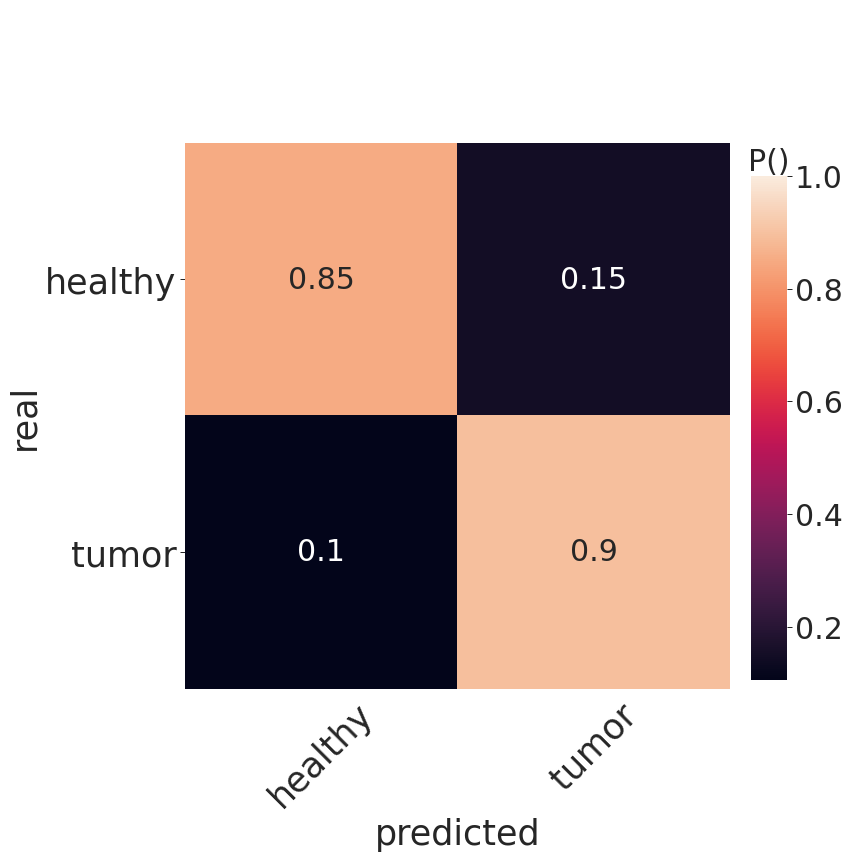

In [298]:
cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    annot_kws={"fontsize":30},
                    cbar_pos=(0.99,0.05,0.05,0.7))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=45)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)

fig.savefig(f"predict_{label}.pdf")

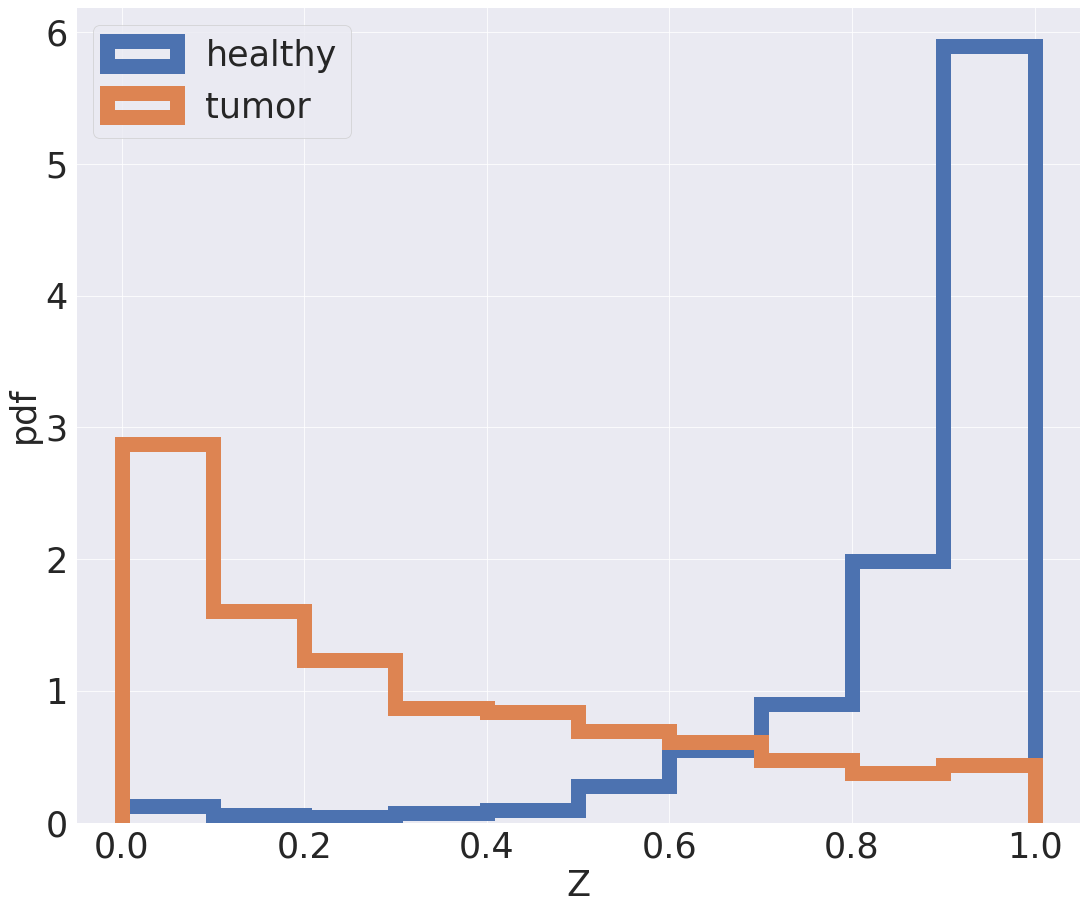

In [312]:
fig, ax= plt.subplots(figsize=(18,15))

if uniq > 1:
  for c in range(uniq):
    ax.hist((1-model.predict(X_test).T[0])[Y_test.argmax(1)==c], histtype="step", lw=15, bins=10, density=True)
else:
  ax.hist(y_pred_p[Y_test==1], histtype="step", lw=15, bins=10, density=True, label="healthy")
  ax.hist(y_pred_p[Y_test==0], histtype="step", lw=15, bins=10, density=True, label="tumor")

ax.tick_params(labelsize=35)
ax.legend(fontsize=35, loc="upper left")
ax.set_title("", fontsize=35)

ax.set_xlim(-0.05,1.05)

ax.set_xlabel("Z", fontsize=35)
ax.set_ylabel("pdf", fontsize=35)

plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_p.T[0])

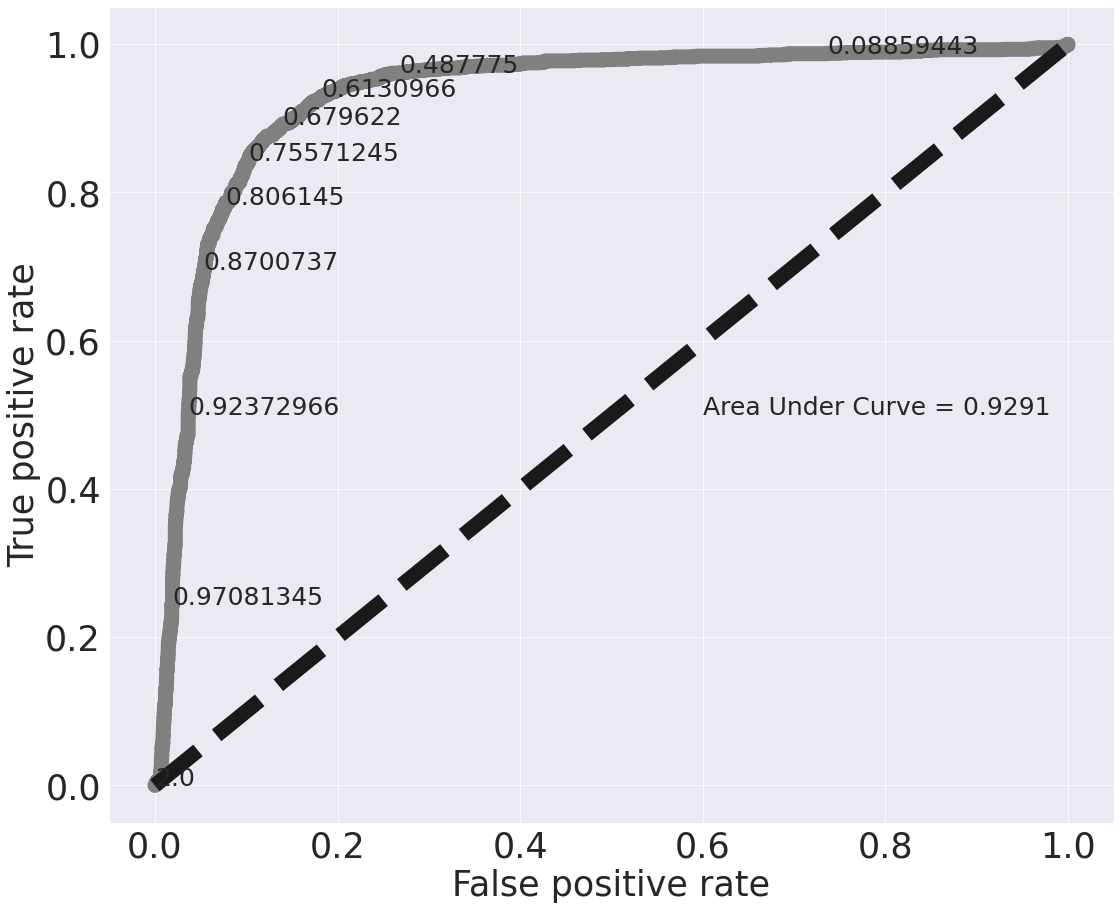

In [311]:
fig, ax = plt.subplots(figsize=(18,15))

ax.plot(fpr,tpr, c="gray", lw=15)

ax.plot([0, 1], [0, 1], 'k--', lw=15)
ax.set_xlabel('False positive rate', fontsize=35)
ax.set_ylabel('True positive rate', fontsize=35)


for f, t, thr in zip(fpr[::100], tpr[::100], thresholds[::100]):
    ax.annotate(thr, (f, t), fontsize=25)

ax.annotate("Area Under Curve = %.4f"%roc_auc_score(y_true, y_pred_p.T[0]), xy=(0.6, 0.5), fontsize=25)

ax.tick_params(labelsize=35)

plt.show()
fig.savefig(f"roc_{label}.pdf")